In [3]:
%load_ext autoreload
%autoreload 2

## Create small of background track to test

In [54]:
import pickle
with open('../results/background_GC_matchedt.pkl', 'rb') as file:
    sequences = pickle.load(file)   

with open('../results/ATAC_backgroundt.pkl', 'rb') as file:
    tracks = pickle.load(file)


In [55]:
sequences.index = sequences.chr + ":" + sequences.start.astype("str") + "-" + sequences.end.astype('str')

In [56]:
sequences = sequences.sample(2, replace=True)
tracks = tracks.loc[sequences.index]
tracks
sequences.iloc[0]

chr                                                         X
start                                                78680000
end                                                  78684096
sequence    ATTTATATATATTCAGAAATTTAAAATTTCATTACAATATAGGTAC...
Name: X:78680000-78684096, dtype: object

In [57]:
with open('../results/background_GC_matchedt.pkl', 'wb') as file:
    pickle.dump(sequences, file)

with open('../results/ATAC_backgroundt.pkl', 'wb') as file:
    pickle.dump(tracks, file)

## Run training on very small subset

In [67]:
!python bias_training.py

cpu
[I 2024-05-10 14:57:31,020] A new study created in memory with name: no-name-a4a24623-079e-414a-829d-c221feae3cf8


## Understand loss behaviour

In [41]:
import pickle
with open('../results/background_GC_matchedt.pkl', 'rb') as file:
    sequences = pickle.load(file)   

with open('../results/ATAC_backgroundt.pkl', 'rb') as file:
    tracks = pickle.load(file)

In [42]:
from data_processing.utils_data_preprocessing import one_hot_encode
import torch
import numpy as np

sequences = sequences.sequence
sequences = sequences.apply(lambda x: one_hot_encode(x))

idx = np.arange(0,70)
track = torch.Tensor(tracks.iloc[idx,0])
input = torch.from_numpy(np.stack(sequences[tracks.index[idx]].values))

input = torch.reshape(input, (-1,4,4096))
track = torch.reshape(track, (-1,1025)).type(torch.float32)

/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_955/1445776227.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  track = torch.Tensor(tracks.iloc[idx,0])


In [43]:
input.shape, track.shape

(torch.Size([70, 4, 4096]), torch.Size([70, 1025]))

In [44]:
import torch
from models import BPNet

m = BPNet()
x, profile, count = m(input)

profile.shape

torch.Size([70, 1024])

In [48]:
from eval_metrics import ATACloss, profile_metrics, counts_metrics

criterion = ATACloss(weight_MSE=1)
loss = criterion(track, profile, count)
loss

(tensor(28.9016, grad_fn=<AddBackward0>),
 tensor(6.8414, grad_fn=<DivBackward1>),
 tensor(22.0602, grad_fn=<MseLossBackward0>))

## Understand validation metrics

In [30]:
profile_metrics(track, profile)

[1.066431545591313,
 1.0060653326400666,
 1.0136956916155455,
 1.0414672489755463,
 1.0218519837907556,
 1.0655539237247016,
 1.0130041749183782,
 1.033495119053954]

In [32]:
counts_metrics(track, count)

0.261904761904762

## Test the main model

In [17]:
import torch
from models import CATAC

m = CATAC(nb_pred=15, nb_cell_type_CN=4, nb_conv=8)
input = torch.randn(32, 4, 4096)
print(input.shape)
x, profile, count = m(input)

profile[10].shape

torch.Size([32, 4, 4096])


torch.Size([32, 1024])

## Test interpretation model with deeplift

In [80]:
from deeplift.dinuc_shuffle import dinuc_shuffle
import torch
import pandas as pd
import numpy
from data_processing.utils_data_preprocessing import one_hot_encode

import shap

def compute_shap_score(model ,seq, back):
    
    back = torch.reshape(back, (-1,4,len(seq)))
    seq = torch.reshape(torch.from_numpy(seq), (-1,4,len(seq)))
    explainer = shap.DeepExplainer(
        model, back)
    raw_scores = explainer.shap_values(seq)
    
    return np.squeeze(raw_scores)

def compute_importance_score(path_model, path_sequence, device):

    #Load the model and sequenece to predict
    model = torch.load(path_model)
    model.to(device)
    seq = pd.read_pickle(path_sequence).sequence.iloc[:5]

    #On-hot encode the sequences
    seq = seq.apply(lambda x: one_hot_encode(x))
    
    #Create shuffled sequences for background
    background = [dinuc_shuffle(s, num_shufs=20) for s in seq]

    #Compute importance score for each base of sequences
    shap_scores = [compute_shap_score(model,s,torch.from_numpy(background[i])) for i,s in enumerate(seq)]

    #Reshape the sequeneces an scores
    seq = np.stack(seq.to_numpy())
    seq = torch.reshape(torch.from_numpy(seq),(-1,4,seq.shape[1]))

    shap_scores = np.stack(shap_scores)

    print(seq.shape, shap_scores.shape)
    
    #Project the scores on the sequence
    proj_score = [s * shap_scores[i] for i,s in enumerate(seq)]
    
    return seq, shap_scores, proj_score


In [72]:
from models import BPNet
model = BPNet()
input = torch.randn(1, 4, 4096)

torch.save(model, '../results/best_biasModel.pt')
outputs = model(input)


In [73]:
print(model)

BPNet(
  (convlayers): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 64, kernel_size=(21,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(2,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(4,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(8,))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(16,))
      (1): ReLU()
    )
    (5): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(32,))
      (1): ReLU()
    )
    (6): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(64,))
      (1): ReLU()
    )
    (7): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(128,))
      (1): ReLU()
    )
  )
  (profile_conv): Conv1d(64, 1, ker

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seq, shap_score, proj_score = compute_importance_score( '../results/best_biasModel.pt',
                                                       '../results/background_GC_matched.pkl', device)

torch.Size([5, 4, 4096]) (5, 4, 4096)


In [92]:
shap_score[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.05537762e-10,  4.10214501e-11, -3.17203791e-10],
       [-2.99523882e-12,  1.92739338e-10,  3.16682819e-10, ...,
        -7.26689986e-10, -2.54490262e-10,  1.38705809e-11],
       [-1.70391793e-12, -2.55363005e-11, -5.32688171e-10, ...,
        -1.99575911e-09, -2.94809142e-11,  3.91135631e-11],
       [ 7.41071093e-11,  6.61300598e-11, -1.54513333e-10, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [96]:
proj_score[0].shape

torch.Size([4, 4096])

Scores for example 0


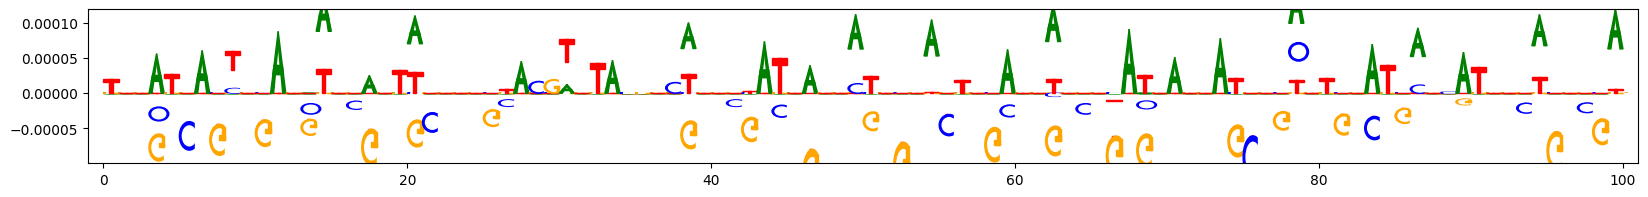

Scores for example 1


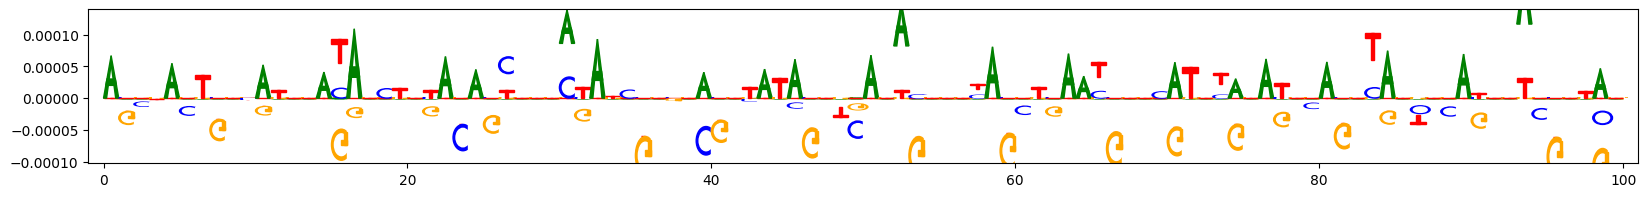

Scores for example 2


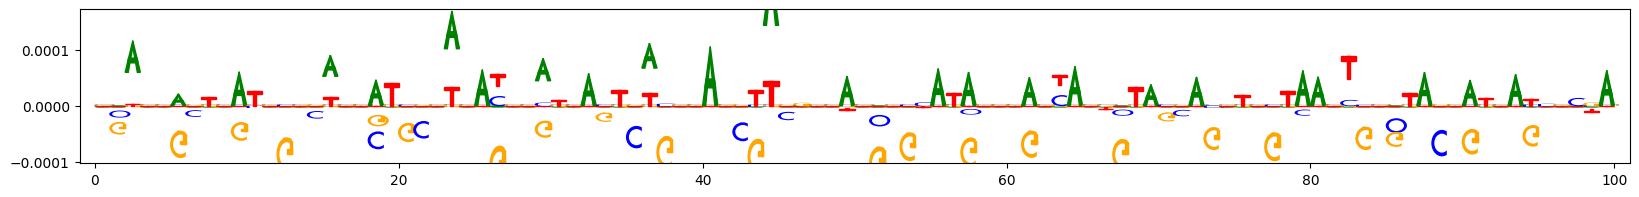

Scores for example 3


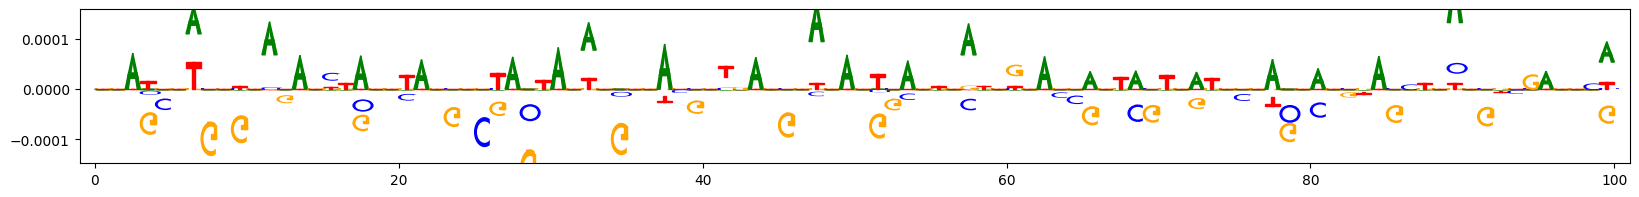

Scores for example 4


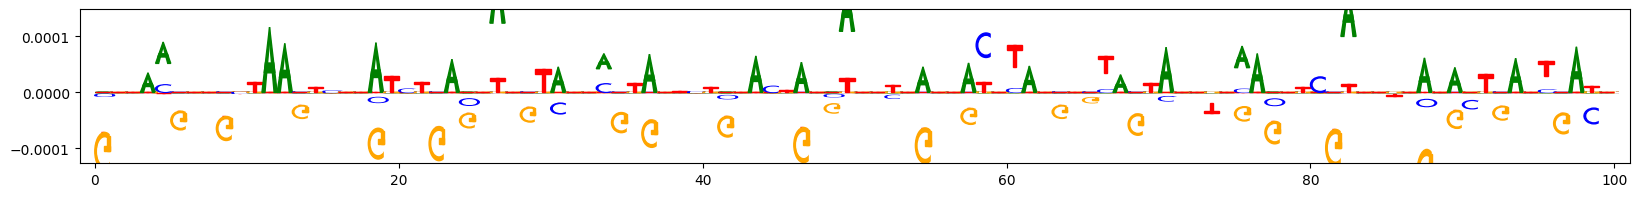

In [98]:

for idx, dinuc_shuff_explanation in enumerate(proj_score):
    print("Scores for example", idx)

    viz_sequence.plot_weights(
        dinuc_shuff_explanation[:,1000:1100], subticks_frequency=20,
    )